# Mejora y segmentación de imagenes médicas

### *Introducción:*
El objetivo de la práctica es realizar una mejora y segmentación de una imagen medica a partir de transformaciones de la imagen médica en una versión:

- más nítida y contrastada,

- con ruido reducido,

- y con regiones anatómicas o patológicas claramente delimitadas (por ejemplo, un tumor o vasos sanguíneos).

Esto permite cuantificar o visualizar zonas específicas para análisis clínico o científico.

Importar librerías

In [3]:
import numpy as np, cv2, pandas as pd, matplotlib.pyplot as plt
import cv2
from google.colab.patches import cv2_imshow
from skimage.filters import threshold_otsu, threshold_local, sobel
from skimage.morphology import remove_small_objects, binary_opening, binary_closing, disk
from skimage.measure import find_contours, label, regionprops_table
from skimage.draw import polygon
from scipy.ndimage import binary_fill_holes, distance_transform_edt
import glob
import nibabel as nib

ModuleNotFoundError: No module named 'cv2'

In [ ]:
#######################################################################################

Cargar la imagen: es la base para poder aplicar filtros o segmentaciones posteriores.

In [5]:
# Leemos la imagen
img = cv2.imread('brain_tumor.jpg', cv2.IMREAD_GRAYSCALE)
plt.imshow(img, cmap='gray');plt.axis('off');plt.show()

NameError: name 'cv2' is not defined

Mostrar los píxeles de la imagen:

Cuando segmentamos una región obtenemos el número de píxeles, pero ese número no tiene significado clínico ya que no se pueden comparar imágenes debido a la diferente resolución.

In [ ]:
def find_pix_dim(dicom_header=None, img_shape=None, fov_mm=(300, 300)):
    """Calcula mm/píxel a partir del tamaño de la imagen y el campo de visión (FOV)."""
    if img_shape is not None:
        n_rows, n_cols = img_shape
        pix_h = fov_mm[0] / n_rows
        pix_w = fov_mm[1] / n_cols
        return pix_w, pix_h
    else:
        return 1.0, 1.0  # valor genérico

# Ejemplo
pix_w, pix_h = find_pix_dim(img_shape=img.shape, fov_mm=(300, 300))  # 300×300 mm
pix_area = pix_w * pix_h
print(f"Pixeles en mm: {pix_w:.3f} x {pix_h:.3f} | Área/píxel = {pix_area:.3f} mm²")

Preprocesado
Ecualización

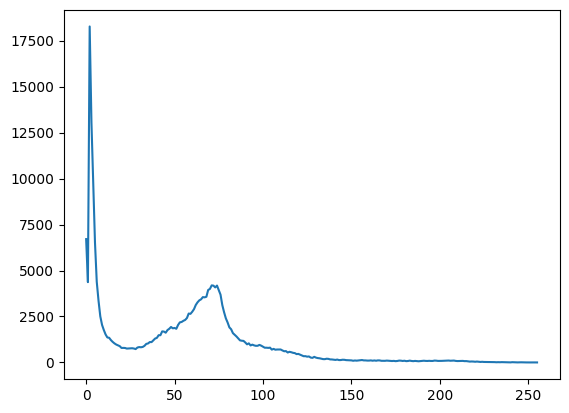

In [ ]:
# Hago histograma
hist = cv2.calcHist([img],[0],None,[256],[0,256])
plt.plot(hist)
plt.show()

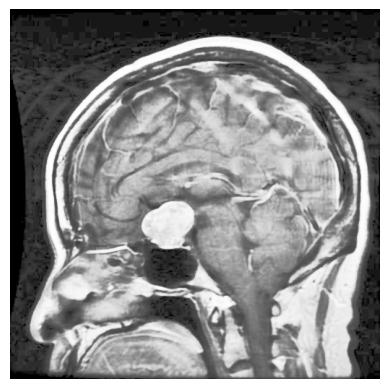

In [ ]:
# Voy a ecualizar
equ = cv2.equalizeHist(img)
plt.imshow(equ, cmap='gray');plt.axis('off');plt.show()

### CLAHE (Contrast Limited Adaptive Histogram Equalization)

CLAHE es preferible para imágenes médicas porque adapta localmente y evita sobre-equalizar.

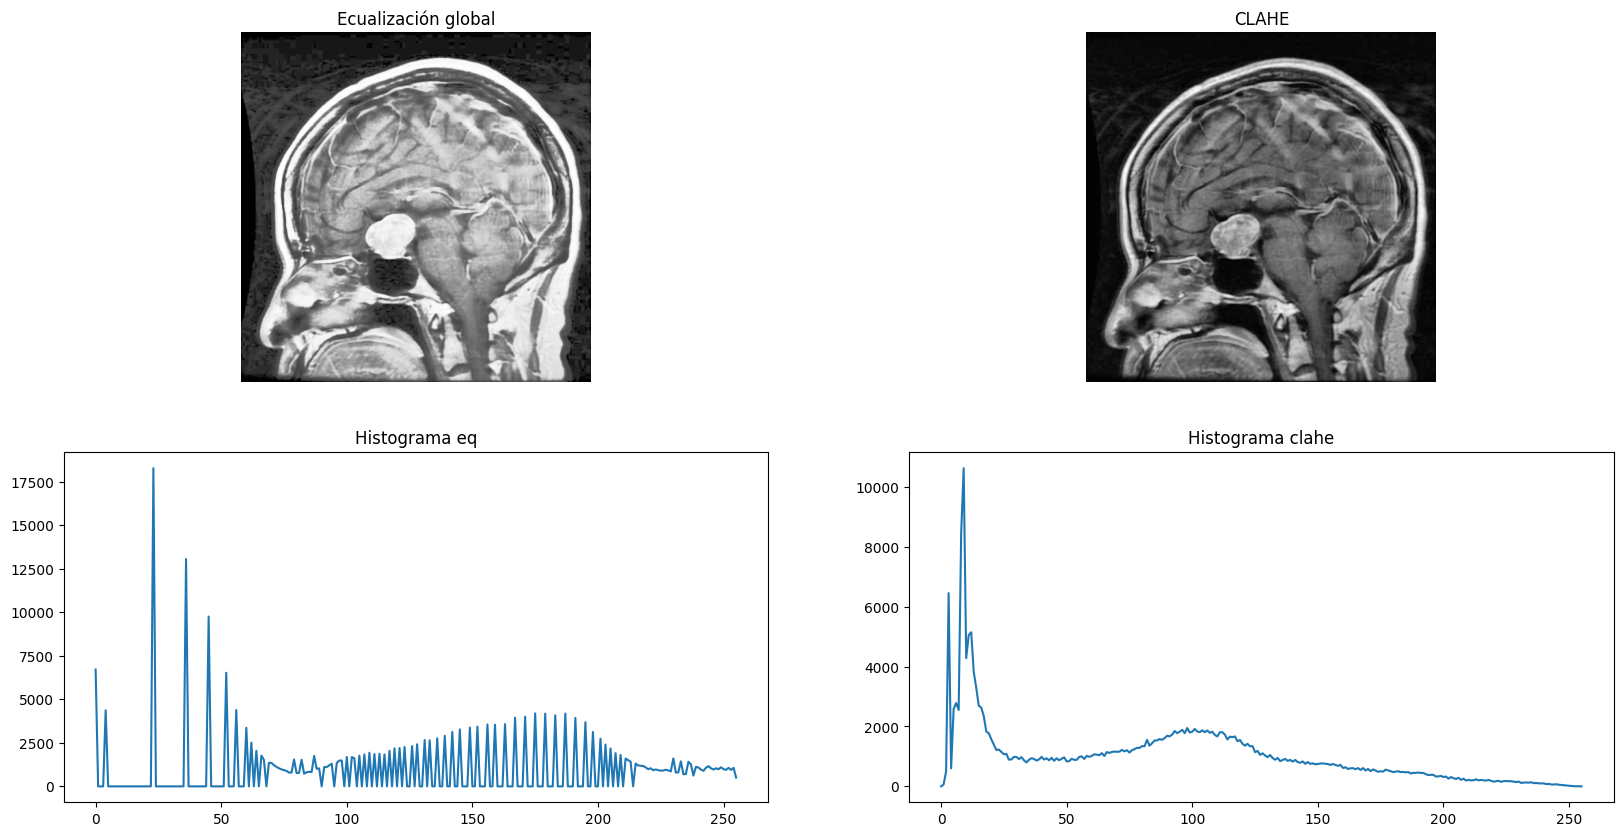

In [ ]:
# Ecualización global
eq = cv2.equalizeHist(img)

# CLAHE mejora el contraste local en zonas oscuras o brillantes.
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
img_clahe = clahe.apply(img)

hist_eq = cv2.calcHist([eq],[0],None,[256],[0,256])
hist_clahe = cv2.calcHist([img_clahe],[0],None,[256],[0,256])
# Mostrar resultados
plt.figure(figsize=(20,10))
plt.subplot(2,2,1); plt.imshow(eq, cmap='gray'); plt.title('Ecualización global'); plt.axis('off')
plt.subplot(2,2,2); plt.imshow(img_clahe, cmap='gray'); plt.title('CLAHE'); plt.axis('off')
plt.subplot(2,2,3); plt.plot(hist_eq);plt.title("Histograma eq")
plt.subplot(2,2,4); plt.plot(hist_clahe);plt.title("Histograma clahe")
plt.show()


El CLAHE ha eliminado ruido de adquisición, es decir, el ruido que provoca un escáner o rayos X. También, aumenta la visibilidad de los bordes y estructuras anatómicas y normaliza las intensidades para que zonas relevantes como los tumores o los vasos sanguíneos se distingan más claramente

### Filtro Gaussiano

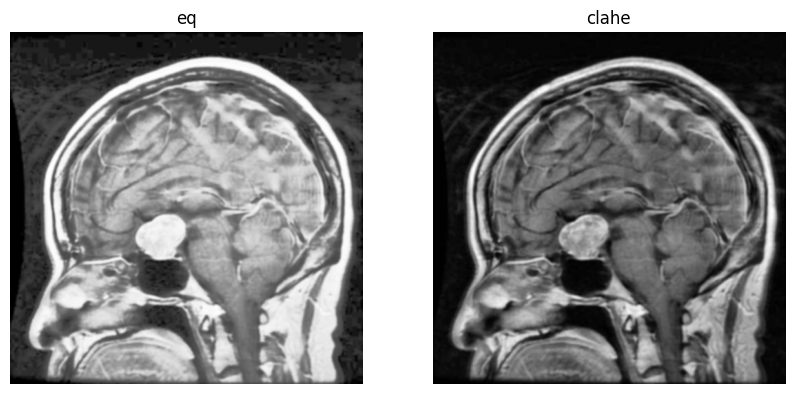

In [ ]:
# Aplico un blur para eliminar los cambios poco importantes
blur_eq = cv2.GaussianBlur(equ, (5,5), 0)
blur_clahe = cv2.GaussianBlur(img_clahe, (5,5), 0)
plt.figure(figsize=(10,5));
plt.subplot(1,2,1); plt.imshow(blur_eq, cmap='gray');plt.axis('off');plt.title("eq")
plt.subplot(1,2,2); plt.imshow(blur_clahe, cmap='gray');plt.axis('off');plt.title("clahe");plt.show()

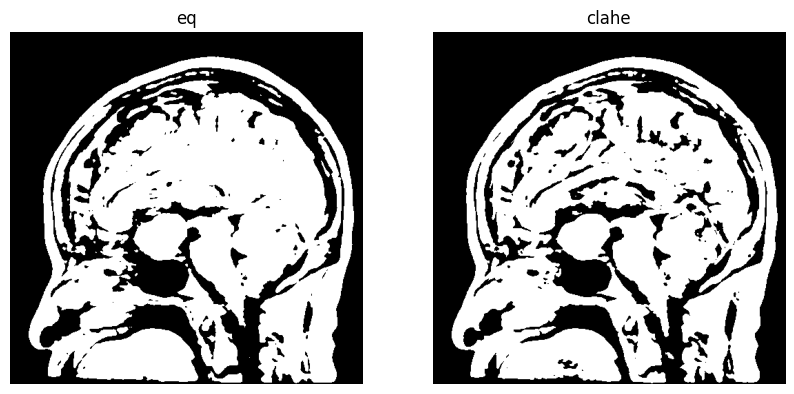

In [ ]:
# Umbralización automática de Otsu
_, thresh_eq = cv2.threshold(blur_eq, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
_, thresh_clahe = cv2.threshold(blur_clahe, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(thresh_eq, cmap='gray');plt.axis('off');plt.title("eq")
plt.subplot(1,2,2); plt.imshow(thresh_clahe, cmap='gray');plt.axis('off');plt.title("clahe");plt.show()

Con la binarización automática, no se identifica claramente la región que queremos

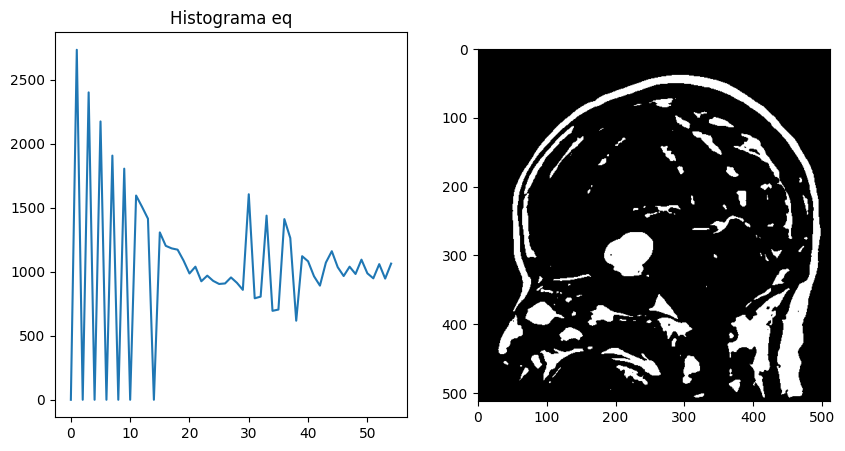

In [ ]:
# Elijo umbral a mano
# Parece que en 230 aparecen perqueños picos en el hist

_, thresh_man = cv2.threshold(blur_eq, 215, 255, cv2.THRESH_BINARY)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.plot(hist_eq[200:255]);plt.title("Histograma eq")
plt.subplot(1,2,2);
plt.imshow(thresh_man, cmap='gray');plt.show()

Ahora sí queda más clara la región

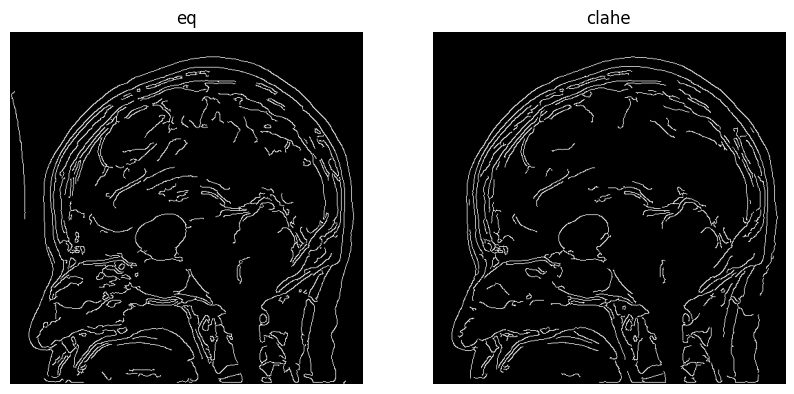

In [ ]:
# Una vez suavizado, detecto los bordes con Canny (Aunque no lo uso para nada)
edges_eq = cv2.Canny(blur_eq, 100, 200)
edges_clahe = cv2.Canny(blur_clahe, 100, 200)
plt.figure(figsize=(10,5))
plt.subplot(1,2,1);
plt.imshow(edges_eq, cmap='gray');plt.axis('off');plt.title("eq")
plt.subplot(1,2,2);
plt.imshow(edges_clahe, cmap='gray');plt.axis('off');plt.title("clahe");plt.show()

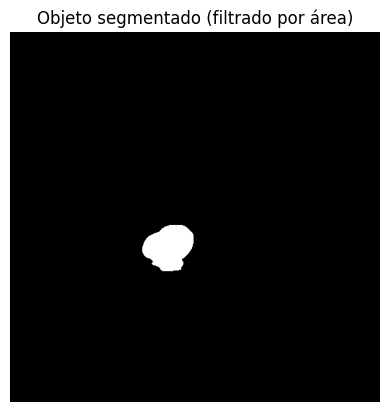

In [ ]:
contours, _ = cv2.findContours(thresh_man, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Filtramos por área
contours_filtrados = [c for c in contours if  cv2.contourArea(c) < 3500]

largest = max(contours_filtrados, key=cv2.contourArea)
if len(contours_filtrados) == 0:
    contours_filtrados = contours
mask_final = np.zeros_like(img)
cv2.drawContours(mask_final, [largest], -1, 255, -1)

plt.imshow(mask_final, cmap='gray')
plt.title("Objeto segmentado (filtrado por área)")
plt.axis('off')
plt.show()

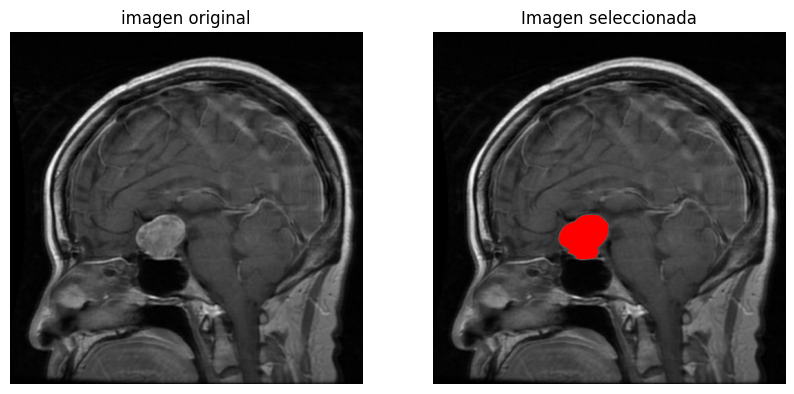

In [ ]:
img_color = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
img_final = img_color.copy()
img_final[mask_final > 0] = (255, 0, 0)


plt.figure(figsize=(10,5))
plt.subplot(1,2,1);
plt.imshow(img, cmap="gray");plt.axis('off');plt.title("imagen original")
plt.subplot(1,2,2);
plt.imshow(img_final);plt.axis('off');plt.title("Imagen seleccionada");plt.show()

In [ ]:
# Calculamos el area del tumor
pix_w, pix_h = find_pix_dim(img_shape=img.shape, fov_mm=(300, 300))
pix_area = pix_w * pix_h

# píxeles donde mask_final > 0 (mismo criterio que usaste para colorear)
num_pixels = np.sum(mask_final > 0)

# área total en mm²
area_mm2 = num_pixels * pix_area

# área en cm²
area_cm2 = area_mm2 / 100

print(f"Nº de píxeles en la lesión: {num_pixels}")
print(f"Área aproximada: {area_mm2:.2f} mm² ({area_cm2:.2f} cm²)")


Nº de píxeles en la lesión: 3287
Área aproximada: 1128.50 mm² (11.29 cm²)


Funciona cuando el tumor es muy claro pero cuando es menos "denso" el método normal falla, por eso usamos el ROI

# IMAGEN 2

# ROI

### Segmentación del ROI anatomica (Region of Interest)

ROI aísla automáticamente la región relevante (por ejemplo, el cerebro o el pulmón) del resto de la imagen.

Se obtiene una máscara binaria clara para análisis posteriores (solo píxeles “anatómicos”).

In [ ]:
# Aplicamos mascara ROI
import numpy as np
from skimage import io, color, exposure
from skimage.filters import threshold_otsu
from skimage.feature import canny
from skimage.morphology import (remove_small_objects, binary_opening, binary_closing,
                                binary_erosion, binary_dilation, disk)
from skimage.measure import label, regionprops
from skimage.segmentation import find_boundaries

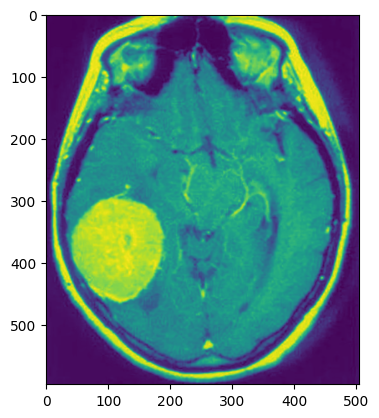

In [ ]:
gray = cv2.imread("tumor3.jpg", cv2.IMREAD_GRAYSCALE)
plt.imshow(gray)

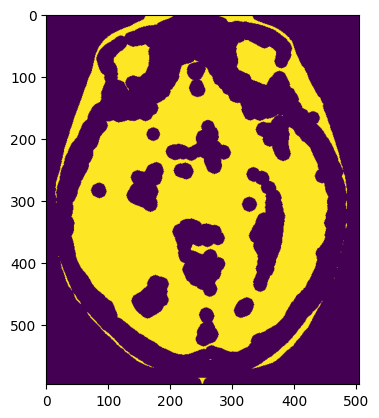

In [ ]:
# Si ya tienes enh y mask_roi, reutilízalos; si no, usa CLAHE sencillo + ROI por Otsu:
enh = exposure.equalize_adapthist(gray, clip_limit=0.01)
T_roi = threshold_otsu(enh)
mask_roi = enh > T_roi
# Limpieza rápida del ROI
mask_roi = remove_small_objects(mask_roi, 500)
mask_roi = binary_closing(mask_roi, disk(3))

# --- 1) Preprocesado dentro del ROI ---
enh_masked = enh * mask_roi
# Para evitar que Canny “coja” el cráneo, erosionamos el ROI unos píxeles
roi_interior = binary_erosion(mask_roi, disk(8))

plt.imshow(roi_interior)

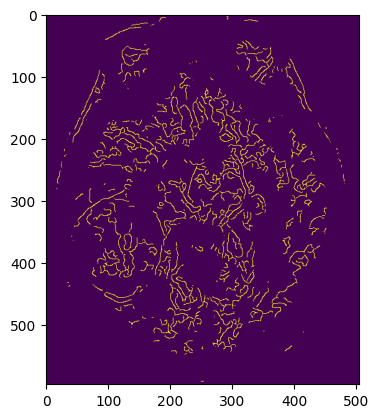

In [ ]:
# --- 2) Canny (solo en el interior del ROI) ---
#Más sigma ⇒ más suavizado: quita ruido y bordes finos; detecta bordes más “gruesos” y continuos.
#Menos sigma ⇒ menos suavizado: conserva detalle fino, pero también más ruido y bordes falsos.


edges = canny(enh, sigma=2.0)  # sigma=2 suele ir bien en MRI; ajusta si hace falta
edges = edges & roi_interior

plt.imshow(edges)

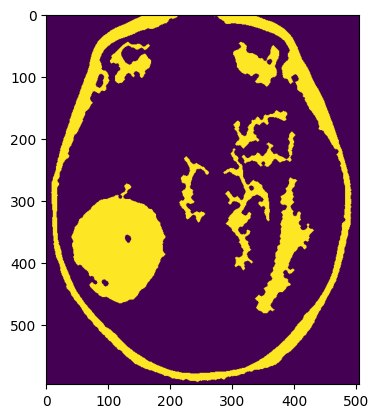

In [ ]:
# --- 3) Máscara de candidatos por intensidad + limpieza ---
T_bin = threshold_otsu(enh_masked[mask_roi])  # Otsu solo dentro del ROI
candidates = (enh_masked > T_bin)
candidates = binary_opening(candidates, disk(2))
candidates = binary_closing(candidates, disk(3))
candidates = remove_small_objects(candidates, min_size=1200)

# (Opcional) reforzar bordes: dilatar edges y hacer AND con candidates para perfilar
edge_band = binary_dilation(edges, disk(2))
candidates = candidates & (binary_dilation(edge_band, disk(3)) | candidates)

plt.imshow(candidates)

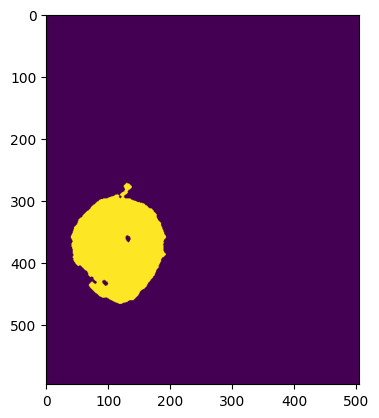

In [ ]:
# --- 4) Etiquetado y filtrado por área/forma/intensidad ---
lab = label(candidates)
props = regionprops(lab, intensity_image=enh)

mask_tumor = np.zeros_like(candidates, dtype=bool)

# Criterios típicos (ajusta a tus datos)
H, W = candidates.shape
min_area = 1200           # píxeles
max_area = 0.15 * H * W   # no aceptar cosas gigantes
min_solidity = 0.80       # tumor suele ser compacto en sagital
best_score, best_label = -1, 0

for r in props:
    area_ok = (r.area >= min_area) and (r.area <= max_area)
    # solidez = area / area del casco convexo (igual a r.solidity)
    sol_ok = (r.solidity or 0) >= min_solidity
    touches_border = r.bbox[0] == 0 or r.bbox[1] == 0 or r.bbox[2] == H or r.bbox[3] == W

    if not (area_ok and sol_ok) or touches_border:
        continue

    # puntuación: grande + brillante + con borde bien definido (más píxeles de edge alrededor)
    mean_int = r.mean_intensity or 0
    perimeter = r.perimeter or 1
    # cuántos bordes Canny hay cerca del contorno (intersección con banda de bordes)
    edge_overlap = np.mean(edge_band[r.coords[:,0], r.coords[:,1]])

    score = (0.5 * mean_int) + (0.3 * np.log1p(r.area)) + (0.2 * edge_overlap)

    if score > best_score:
        best_score = score
        best_label = r.label

if best_label != 0:
    mask_tumor = (lab == best_label)
    # rellenar huecos pequeños
    mask_tumor = binary_closing(mask_tumor, disk(3))
    mask_tumor = binary_dilation(mask_tumor, disk(1))

plt.imshow(mask_tumor)

(np.float64(-0.5), np.float64(504.5), np.float64(595.5), np.float64(-0.5))

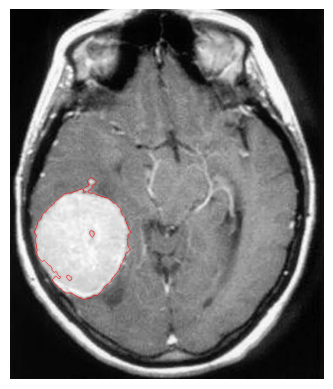

In [ ]:
base_u8 = gray.astype(np.uint8)                   # 0..255
overlay = np.dstack([base_u8, base_u8, base_u8])  # 3 canales uint8
outline = find_boundaries(mask_tumor, mode="outer")

overlay[outline] = (255, 0, 0)                    # rojo en uint8

plt.imshow(overlay)
plt.axis('off')


In [ ]:
#####################FILIP BASURA


# IMAGENES CT

In [ ]:
#Descargamos las imagenes

!echo "Loading data"
!pip install gdown
!gdown https://drive.google.com/uc?id=1qNpH_0BEy-JJE5VMNfb8kuNN2KfsFLsi
!unzip Images.zip

Loading data
Downloading...
From: https://drive.google.com/uc?id=1qNpH_0BEy-JJE5VMNfb8kuNN2KfsFLsi
To: /content/Images.zip
100% 7.85M/7.85M [00:00<00:00, 100MB/s]
Archive:  Images.zip
   creating: Images/
  inflating: Images/slice001.nii.gz  
  inflating: Images/slice002.nii.gz  
  inflating: Images/slice003.nii.gz  
  inflating: Images/slice004.nii.gz  
  inflating: Images/slice005.nii.gz  
  inflating: Images/slice006.nii.gz  
  inflating: Images/slice007.nii.gz  
  inflating: Images/slice008.nii.gz  
  inflating: Images/slice009.nii.gz  
  inflating: Images/slice010.nii.gz  
  inflating: Images/slice011.nii.gz  
  inflating: Images/slice012.nii.gz  
  inflating: Images/slice013.nii.gz  
  inflating: Images/slice014.nii.gz  
  inflating: Images/slice015.nii.gz  
  inflating: Images/slice016.nii.gz  
  inflating: Images/slice017.nii.gz  
  inflating: Images/slice018.nii.gz  
  inflating: Images/slice019.nii.gz  
  inflating: Images/slice020.nii.gz  
  inflating: Images/slice021.nii.gz

In [ ]:
def show_slice(slice):
    """
    Function to display an image slice
    Input is a numpy 2D array
    """
    plt.figure()
    plt.imshow(slice.T, cmap="gray", origin="lower")


def overlay_plot(im, mask):
    plt.figure()
    plt.imshow(im.T, 'gray', interpolation='none')
    plt.imshow(mask.T, 'jet', interpolation='none', alpha=0.5)

    basepath = './Images/slice*.nii.gz'
paths = sorted(glob.glob(basepath))
print('Images found:', len(paths))

#Imprimimos las 21 imagenes(cortes) que hemos descargado

for c, exam_path in enumerate(paths):
    ct_img = nib.load(exam_path)
    ct_numpy = ct_img.get_fdata()
    show_slice(ct_numpy)
    if c == 3:
      break


NameError: name 'glob' is not defined

In [ ]:
basepath = './Images/slice*.nii.gz'
paths = sorted(glob.glob(basepath))
print('Images found:', len(paths))

for c, exam_path in enumerate(paths):
    ct_img = nib.load(exam_path)
    ct_numpy = ct_img.get_fdata()
    show_slice(ct_numpy)
    if c == 3:
      break

In [ ]:
# Cargamos solo la primera imagen (primer archivo)
exam_path = paths[0]
ct_img = nib.load(exam_path)
ct_numpy = np.asanyarray(ct_img.dataobj)

# Seleccionar un 2D para mostrar según dimensionalidad
if ct_numpy.ndim == 2:
    img2d = ct_numpy
elif ct_numpy.ndim == 3:
    img2d = ct_numpy[:, :, ct_numpy.shape[2] // 2]   # corte axial central
elif ct_numpy.ndim == 4:
    vol3d = ct_numpy[..., 0]                          # primer volumen/canal
    img2d = vol3d[:, :, vol3d.shape[2] // 2]
else:
    raise ValueError(f"ndim={ct_numpy.ndim} no soportado")

show_slice(img2d)
plt.show()


La absorción de rayos X se mide en la escala de Hounsfield. En esta escala, fijamos la intensidad del aire en -1000 y la del agua en 0. Es fundamental comprender que Hounsfield es una escala absoluta, a diferencia de la resonancia magnética, donde tenemos una escala relativa de 0 a 255.

En las imagenes CT podemos usar ventanas y niveles que nos permiten ver distintas capas en **una sola imagen** dependiendo de la densidad del tejido

In [ ]:
def show_slice_window(slice, level, window):
   """
   Function to display an image slice
   Input is a numpy 2D array
   """
   max = level + window/2
   min = level - window/2
   slice = slice.clip(min,max)
   plt.figure()
   plt.imshow(slice.T, cmap="gray", origin="lower")
   plt.savefig('L'+str(level)+'W'+str(window))

In [ ]:
# 2) Aplicar distintas ventanas (L/W)

show_slice_window(img2d, level=-600, window=1500)  # Lungs
plt.title("Pulmones")
plt.show()

show_slice_window(img2d, level=50, window=350)     # Soft tissues
plt.title("Hueso")
plt.show()


show_slice_window(img2d, level=400, window=1800)   # Bone
plt.title("Higado")
plt.show()

show_slice_window(img2d, level=30, window=150)      # Brain
plt.title("Higado")
plt.show()
